In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/proj_energy_volatility


In [2]:
from src.trading.IBKR_trading import TradingApp
from dotenv import load_dotenv
from ib_insync import *
import pandas as pd
import matplotlib.pyplot as plt

import logging
logging.getLogger('ib_insync.ib').setLevel(logging.ERROR)

In [3]:
plt.style.use("styler.mplstyle") 
load_dotenv()

True

In [4]:
HOST = os.getenv("IB_HOST")

PORT = int(os.getenv("IB_PORT"))
CLIENT_ID = int(os.getenv("IB_CLIENT_ID"))
ib = IB()
await ib.connectAsync(HOST, PORT, clientId=CLIENT_ID)


<IB connected to 192.168.1.145:7497 clientId=999>

In [5]:

file_path = os.path.join(repo_root, 'data', 'stock_tickers.csv')
tickers = pd.read_csv(file_path)

In [6]:
energy_sector = tickers[tickers['Sector'] == 'Energy'].sort_values(by=['Market Cap'], ascending=False)

In [7]:
energy_sector

,Unnamed: 0,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
9954,6921,XOM,Exxon Mobil Corporation Common Stock,$117.22,2.7200,2.376%,4.943362e+11,United States,NaN,17177678,Energy,Integrated oil Companies
4761,1728,CVX,Chevron Corporation Common Stock,$155.02,2.0800,1.36%,3.145728e+11,United States,NaN,9835318,Energy,Integrated oil Companies
8735,5702,SHEL,Shell PLC American Depositary Shares (each rep...,$75.59,1.3700,1.846%,2.196431e+11,Netherlands,2022.0,3630522,Energy,Oil & Gas Production
3894,861,BHP,BHP Group Limited American Depositary Shares (...,$55.16,-0.4500,-0.809%,1.400764e+11,Australia,NaN,3965159,Energy,Coal Mining
9411,6378,TTE,TotalEnergies SE,$62.26,1.1500,1.882%,1.358427e+11,France,NaN,743815,Energy,Oil & Gas Production
...,...,...,...,...,...,...,...,...,...,...,...,...
5635,2602,GBR,New Concept Energy Inc Common Stock,$0.87,-0.0400,-4.396%,4.464783e+06,United States,1993.0,22403,Energy,Oil & Gas Production
6103,3070,HTOO,Fusion Fuel Green PLC Class A Ordinary Shares,$3.89,0.0600,1.567%,3.047333e+06,Ireland,NaN,31621,Energy,Industrial Machinery/Components
6104,3071,HTOOW,Fusion Fuel Green PLC Warrant,$0.0193,-0.0006,-3.015%,1.511900e+04,Ireland,NaN,31615,Energy,Industrial Machinery/Components
1715,1715,METCZ,Ramaco Resources Inc. 8.375% Senior Notes due ...,$25.42,-0.0150,-0.059%,0.000000e+00,United States,NaN,1726,Energy,Coal Mining


In [8]:
top_5 = energy_sector['Symbol'].head(5).to_list()

In [9]:
from ib_insync import IB, Stock, util

async def get_stock(ib: IB, symbol: str, duration: str, bar_size: str, what: str, rth: bool = True):
    """
    symbol: 'AAPL'
    duration: '1 D', '5 D', '1 W', '1 M', '1 Y', '2 Y', etc.
    bar_size: '1 min', '5 mins', '15 mins', '1 hour', '1 day', etc.
    what: 'TRADES', 'MIDPOINT', 'BID', 'ASK'
    rth: True to restrict to regular trading hours
    """
    valid_what = {'TRADES','MIDPOINT','BID','ASK'}
    if what not in valid_what:
        raise ValueError(f"'what' must be one of {valid_what}")

    # Build & qualify a resolvable contract
    contract = Stock(symbol=symbol, exchange='SMART', currency='USD')
    await ib.qualifyContractsAsync(contract)

    print(f"\n=== {symbol} | duration={duration} | bar_size={bar_size} | what={what} | RTH={rth} ===")

    bars = await ib.reqHistoricalDataAsync(
        contract=contract,
        endDateTime='',             # now
        durationStr=duration,       
        barSizeSetting=bar_size,    
        whatToShow=what,            
        useRTH=rth,                 
        formatDate=1,
        keepUpToDate=False
    )

    if not bars:
        print("No bars returned. Common causes:")
        print("- Duration too long for the bar size (IBKR limits combos).")
        print("- Wrong 'whatToShow' for this symbol/market hours.")
        print("- Contract permissions/region not enabled.")
        print("- Holiday/weekend + useRTH=True. Try useRTH=False or what='MIDPOINT'.")

    return util.df(bars)


In [10]:
df = await get_stock(ib, 'EXE', '2 Y', '1 day', 'TRADES', rth=True)


=== EXE | duration=2 Y | bar_size=1 day | what=TRADES | RTH=True ===


In [11]:
df

,date,open,high,low,close,volume,average,barCount
0,2023-11-09,81.68,81.97,80.41,80.49,543345.0,80.793,4602
1,2023-11-10,81.00,81.18,78.27,79.09,1319206.0,79.007,9976
2,2023-11-13,80.17,80.85,79.33,80.01,688948.0,80.222,5281
3,2023-11-14,80.15,81.87,80.00,81.54,515149.0,81.427,3927
4,2023-11-15,81.21,83.71,80.98,83.25,948115.0,82.846,6252
...,...,...,...,...,...,...,...,...
495,2025-11-03,103.73,110.35,103.03,110.08,2262559.0,107.853,14410
496,2025-11-04,109.46,111.77,108.14,110.05,1752188.0,109.829,11460
497,2025-11-05,109.42,112.45,108.74,110.05,1346454.0,111.080,8883
498,2025-11-06,110.61,112.63,109.10,110.62,1083207.0,110.641,7037


In [12]:
data = {}

for stock in top_5:
    df = await get_stock(ib, stock, '2 Y', '1 day', 'TRADES', rth=False)
    if df is not None:
        df['symbol'] = stock
        df = df.set_index('date')
        data[stock] = df['close']  # Use closing prices for clean comparison


=== XOM | duration=2 Y | bar_size=1 day | what=TRADES | RTH=False ===

=== CVX | duration=2 Y | bar_size=1 day | what=TRADES | RTH=False ===

=== SHEL | duration=2 Y | bar_size=1 day | what=TRADES | RTH=False ===

=== BHP | duration=2 Y | bar_size=1 day | what=TRADES | RTH=False ===

=== TTE | duration=2 Y | bar_size=1 day | what=TRADES | RTH=False ===


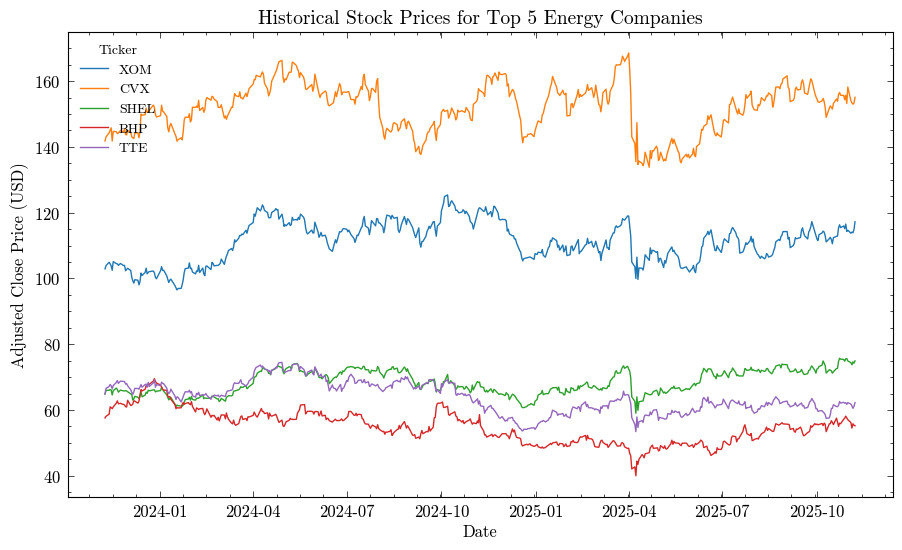

In [15]:
combined = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")

combined.plot(ax=ax)

ax.set_title('Historical Stock Prices for Top 5 Energy Companies', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price (USD)')
ax.legend(title='Ticker')

plt.show()